d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


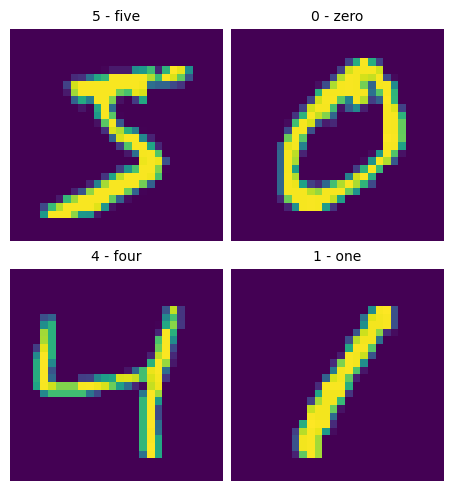

15738
path                                         module                                       input size               output size              params    buffers   
__main__.CNN/c1/0                            torch.nn.modules.conv.Conv2d                 (1, 1, 28, 28)           (1, 16, 25, 25)          272       0         
__main__.CNN/c1/1                            torch.nn.modules.pooling.MaxPool2d           (1, 16, 25, 25)          (1, 16, 12, 12)          0         0         
__main__.CNN/c1/2                            torch.nn.modules.activation.ReLU             (1, 16, 12, 12)          (1, 16, 12, 12)          0         0         
__main__.CNN/c2/0                            torch.nn.modules.conv.Conv2d                 (1, 16, 12, 12)          (1, 32, 10, 10)          4640      0         
__main__.CNN/c2/1                            torch.nn.modules.pooling.MaxPool2d           (1, 32, 10, 10)          (1, 32, 5, 5)            0         0         
__main__.CNN/c2/2           

In [1]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets import MNIST
dstrain, dstest = MNIST.get_mnist_classification()
dstrain.preview()

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = conv(1, 16, 4, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2,2))
        self.c2 = conv(16, 32, 3, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.c3 = conv(32, 64, 2, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.linear = linear(256, 10, act=nn.Softmax(dim=1), flatten=True)
    
    def forward(self,x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.linear(x)
        return x

print(count_parameters(CNN()))
summary(CNN(), (1, 1, 28,28))
#torchinfo.summary(CNN(), (1, 1, 40))

# vanilla 1st-order random walk 1e-3 bestof 1 - 54% test accuracy
We start with basic 1st-order random walk. This simply tries a random direction, if loss decreases, steps in that direction, if loss increased, steps in the opposite direction.

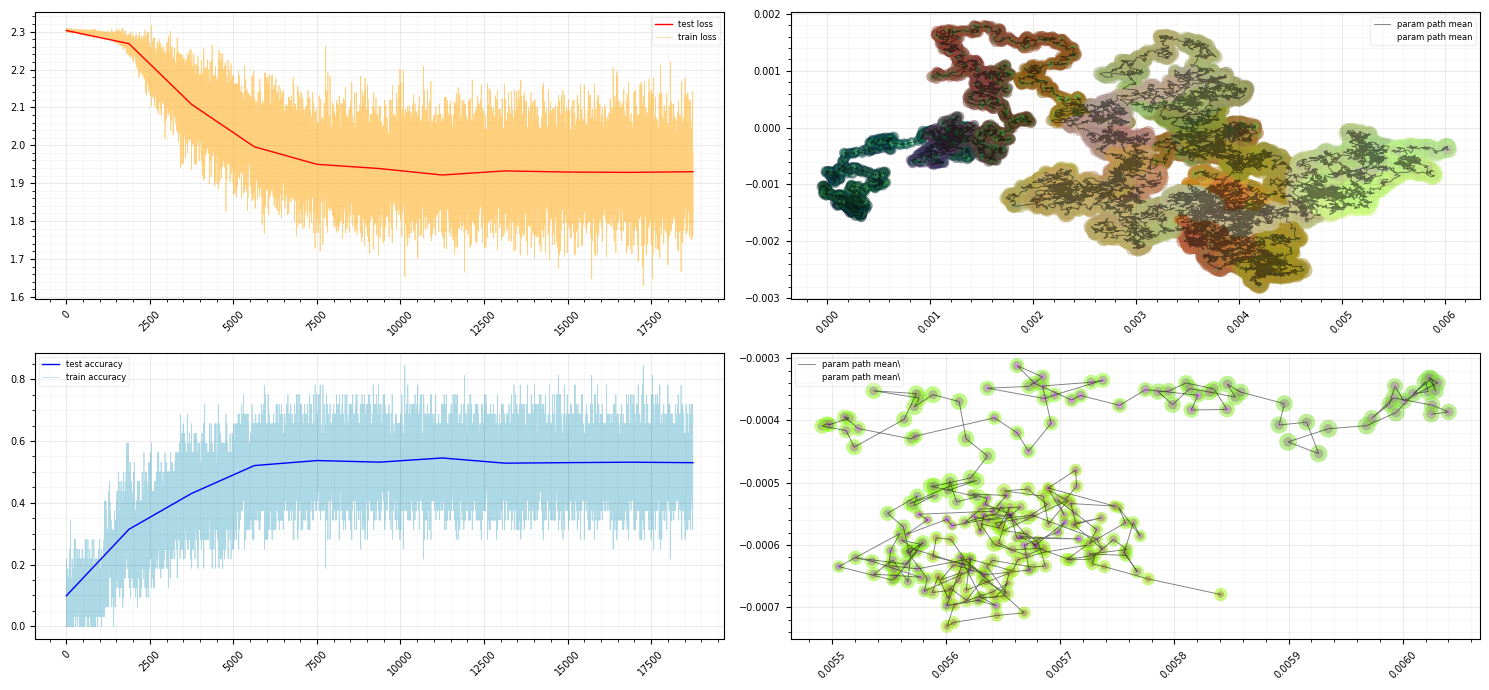

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 40.24s/ops, elapsed: 06m:02s, rem: 40.24s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 269.36ops/s, elapsed: 1.16s, rem: 4ms | 
train loss:                              last = 1.799, min = 1.628, max = 2.316
test loss:                               last = 1.928, min = 1.922, max = 2.303
train accuracy:                          last = 0.656, min = 0.000, max = 0.844
test accuracy:                           last = 0.531, min = 0.099, max = 0.545

test loss: min: 1.9216; max: 2.3029; last: 1.9303
test accuracy: min: 0.0989; max: 0.5450; last: 0.5299
param mean: min: -0.0001; max: 0.0034; last: 0.0034
param var: min: 0.0026; max: 0.0218; last: 0.0218
param min: min: -0.6668; max: -0.2446; last: -0.6318
param max: min: 0.2436; max: 0.5923; last: 0.5891
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0067; max: 0.0197; last: 0.0068
time: min: 1.8729; max: 402.3798; last: 402.3798
train loss: min: 1.6282; max: 2.3163; last: 1.7989
train accuracy: min: 0.0000; max: 0.8438; last: 0.6562
last updates std: min: 0.0005; max: 0.0006; last: 0.0005


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=1, best_of=1)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"1st-order random walk {LR:.0e} bestof1"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# 1st-order random walk 2e-3 bestof 1 + cosine lr decay to 0 - 60% test accuracy
It gets stuck - lets add lr decay. Also unlike gradient descent, schedulers like one cycle or cyclic annealing don't seem to help.

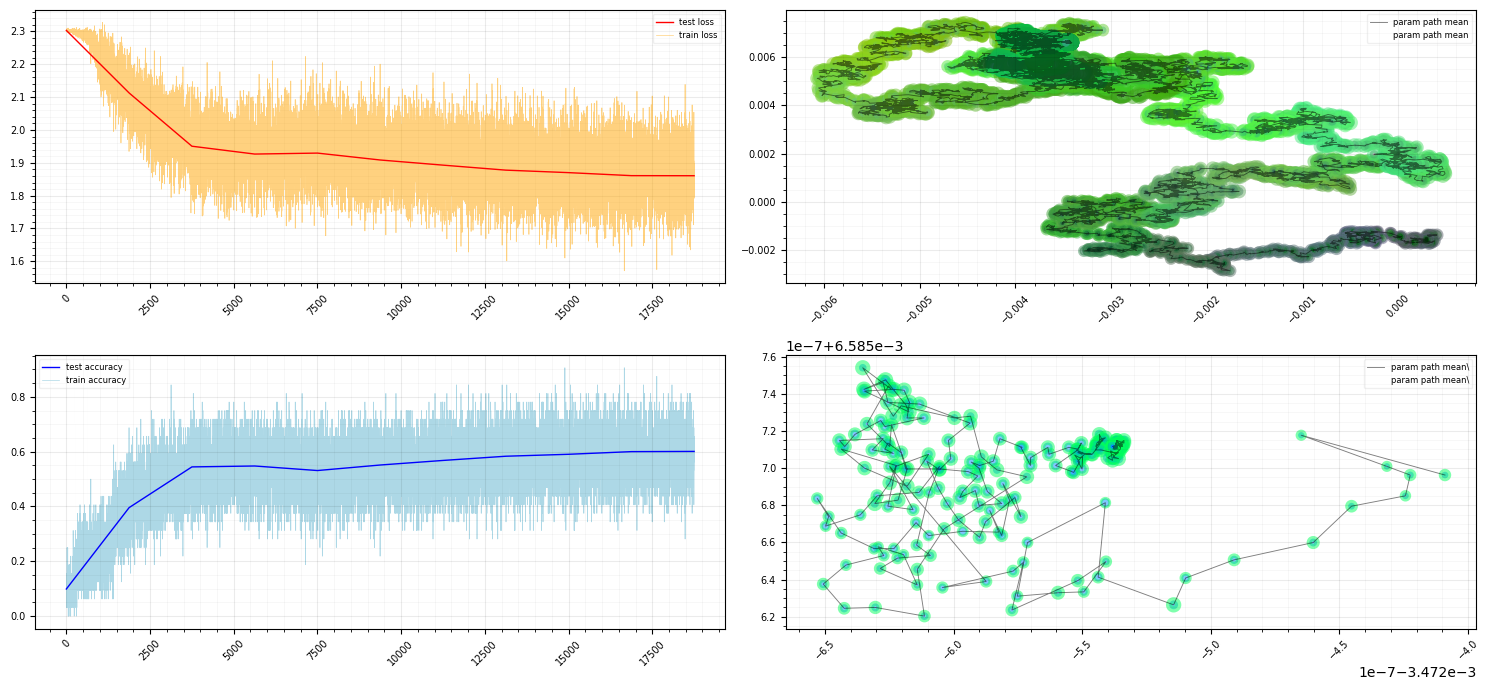

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 41.82s/ops, elapsed: 06m:16s, rem: 41.82s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 225.30ops/s, elapsed: 1.38s, rem: 4ms | 
train loss:                              last = 1.898, min = 1.571, max = 2.327
test loss:                               last = 1.861, min = 1.861, max = 2.303
train accuracy:                          last = 0.562, min = 0.000, max = 0.906
test accuracy:                           last = 0.600, min = 0.099, max = 0.600

test loss: min: 1.8606; max: 2.3029; last: 1.8606
test accuracy: min: 0.0989; max: 0.6009; last: 0.6009
param mean: min: -0.0003; max: 0.0030; last: 0.0024
param var: min: 0.0026; max: 0.0310; last: 0.0310
param min: min: -0.8150; max: -0.2477; last: -0.7745
param max: min: 0.2485; max: 0.6894; last: 0.6824
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0393; last: 0.0000
time: min: 1.7967; max: 422.2362; last: 422.2362
train loss: min: 1.5713; max: 2.3273; last: 1.8983
train accuracy: min: 0.0000; max: 0.9062; last: 0.5625
last updates std: min: 0.0000; max: 0.0011; last: 0.0000


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [3]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 2e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=1, best_of=1)
SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS * len(DLTRAIN))

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"1st-order random walk {LR:.0e} bestof1 + cosine lr decay to 0"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# 1st-order random walk 2e-3 bestof 3 + cosine lr decay to 0 - 60% test accuracy
With `bestof` = 3 it evaluates model 3+1 = 4 times per step.

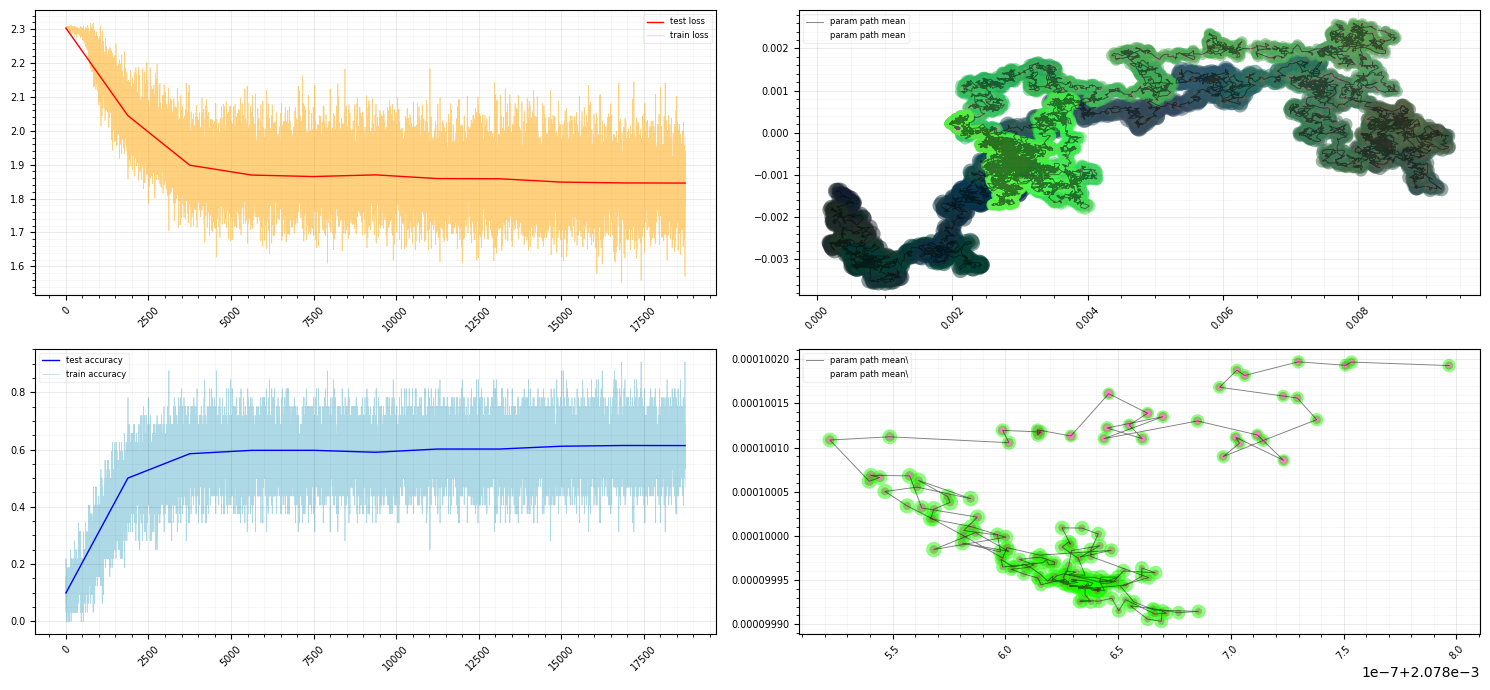

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 54.83s/ops, elapsed: 08m:13s, rem: 54.83s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 261.59ops/s, elapsed: 1.19s, rem: 4ms | 
train loss:                              last = 1.983, min = 1.553, max = 2.318
test loss:                               last = 1.846, min = 1.846, max = 2.303
train accuracy:                          last = 0.469, min = 0.000, max = 0.906
test accuracy:                           last = 0.614, min = 0.099, max = 0.614

test loss: min: 1.8458; max: 2.3029; last: 1.8458
test accuracy: min: 0.0989; max: 0.6140; last: 0.6137
param mean: min: 0.0001; max: 0.0041; last: 0.0037
param var: min: 0.0026; max: 0.0306; last: 0.0306
param min: min: -0.6410; max: -0.2477; last: -0.6244
param max: min: 0.2467; max: 0.7710; last: 0.7300
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0391; last: 0.0000
time: min: 1.8064; max: 559.5602; last: 559.5602
train loss: min: 1.5526; max: 2.3181; last: 1.9829
train accuracy: min: 0.0000; max: 0.9062; last: 0.4688
last updates std: min: 0.0000; max: 0.0011; last: 0.0000


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 2e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=1, best_of=3)
SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS * len(DLTRAIN))

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"1st-order random walk {LR:.0e} bestof3 + cosine lr decay to 0"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# vanilla 2nd-order random walk 1e-3 bestof 1 - 10% test accuracy
2nd order random walk tries a petrubation to current movement direction, if loss decreases, applies it, if loss decreases, applies an opposite petrubation.

We start with the same 1e-3 lr with no scheduler, which is too high. We can see on the path that it just keeps moving in one general direction, and it never overcame random guessing accuracy. Picking the right higher-order lr is very tricky, because with both too large and too small lrs it picks up a lot of momentum on large or small scale convex parts and isn't able to steer itself quickly enough.

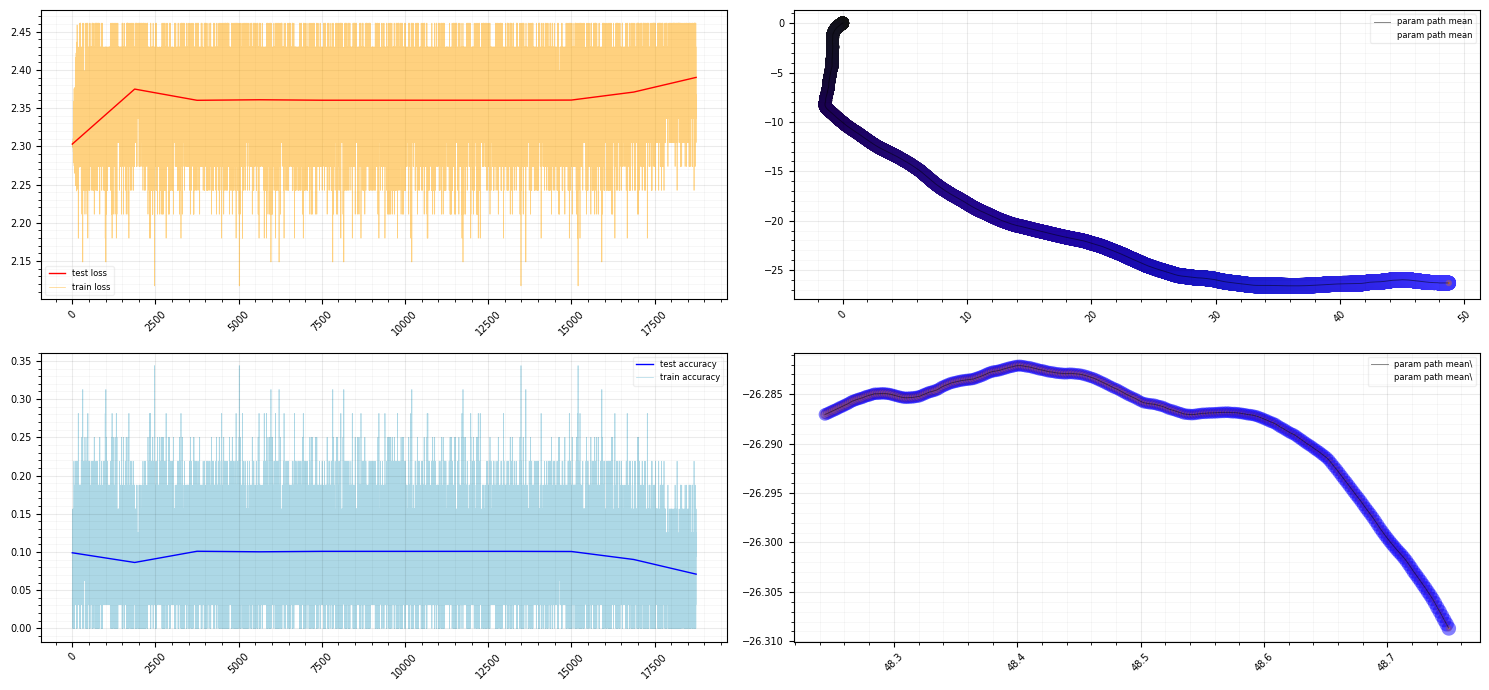

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 41.57s/ops, elapsed: 06m:14s, rem: 41.57s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 236.44ops/s, elapsed: 1.32s, rem: 4ms | 
train loss:                              last = 2.430, min = 2.117, max = 2.461
test loss:                               last = 2.371, min = 2.303, max = 2.375
train accuracy:                          last = 0.031, min = 0.000, max = 0.344
test accuracy:                           last = 0.090, min = 0.086, max = 0.101

test loss: min: 2.3029; max: 2.3902; last: 2.3902
test accuracy: min: 0.0710; max: 0.1009; last: 0.0710
param mean: min: -1.9444; max: 7.7764; last: 7.7764
param var: min: 0.0026; max: 2169434.0000; last: 2169434.0000
param min: min: -6212.8984; max: -0.2494; last: -6212.8984
param max: min: 0.2471; max: 5831.1714; last: 5831.1714
update var: min: 0.0000; max: 0.0067; last: 0.0067
update angle: min: 0.0000; max: 0.0698; last: 0.0000
time: min: 1.5858; max: 420.2890; last: 420.2890
train loss: min: 2.1174; max: 2.4612; last: 2.4299
train accuracy: min: 0.0000; max: 0.3438; last: 0.0312
last updates std: min: 0.0000; max: 0.0776; last: 0.0006


In [3]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=1)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof1"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# 2nd-order random walk 2e-3 bestof 1 + cosine lr decay to 0 - 11% test accuracy
I've also tried same hyperparams as for 1st order random walk with cosine lr decay, however it went too far at the beginning which probably messed up the weights beyond recovery. Seeing the path legend having values bigger than 1 is never a good sign. Moreover, it builds a lot of momentum at the beginning, and since the learning rate decays, it simply doesn't have enough power to steer away from that momentum.

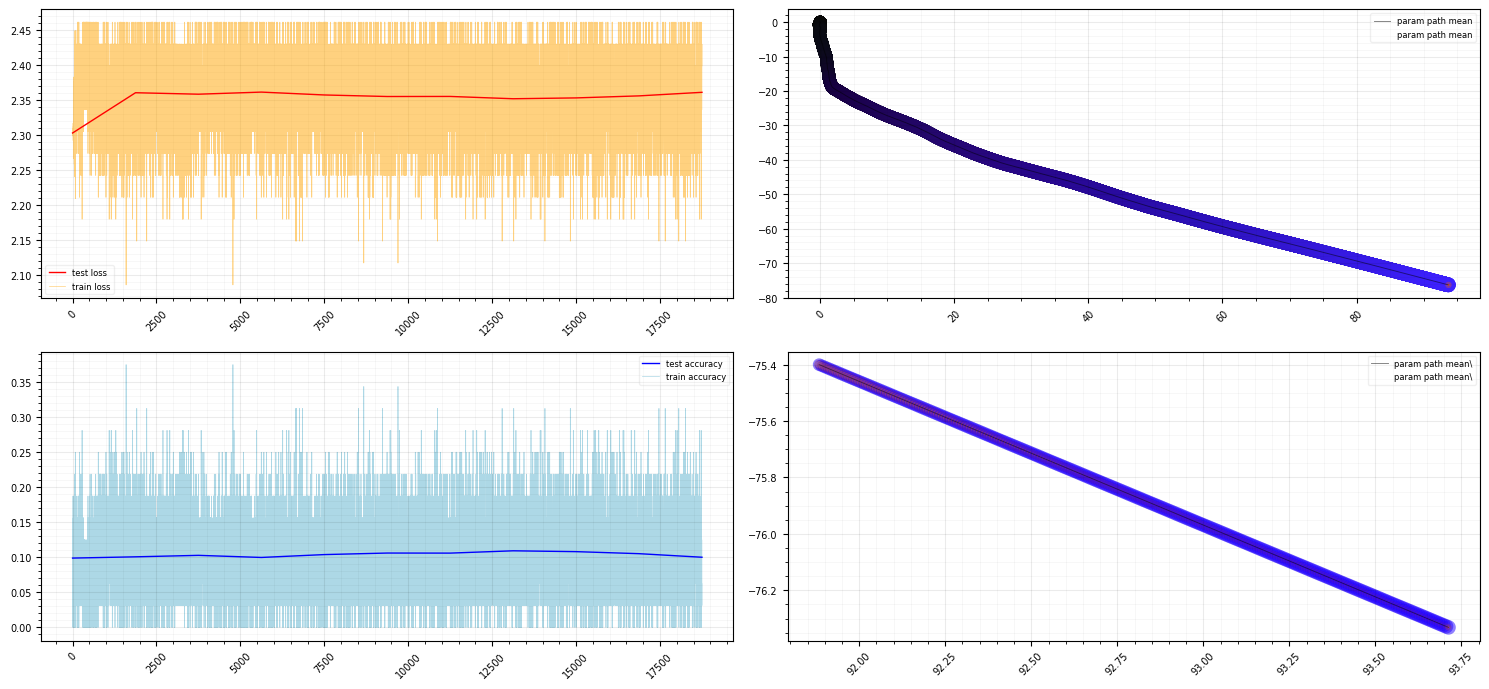

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 41.21s/ops, elapsed: 06m:10s, rem: 41.21s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 271.74ops/s, elapsed: 1.15s, rem: 4ms | 
train loss:                              last = 2.399, min = 2.086, max = 2.461
test loss:                               last = 2.356, min = 2.303, max = 2.361
train accuracy:                          last = 0.062, min = 0.000, max = 0.375
test accuracy:                           last = 0.105, min = 0.099, max = 0.109

test loss: min: 2.3029; max: 2.3613; last: 2.3610
test accuracy: min: 0.0989; max: 0.1093; last: 0.1001
param mean: min: -1.4879; max: 17.0604; last: 17.0604
param var: min: 0.0026; max: 6069597.5000; last: 6069597.5000
param min: min: -10118.6914; max: -0.2494; last: -10118.6914
param max: min: 0.2485; max: 10472.0381; last: 10472.0381
update var: min: 0.0000; max: 0.0100; last: 0.0100
update angle: min: 0.0000; max: 0.1348; last: 0.0000
time: min: 1.7420; max: 416.3150; last: 416.3150
train loss: min: 2.0862; max: 2.4612; last: 2.3987
train accuracy: min: 0.0000; max: 0.3750; last: 0.0625
last updates std: min: 0.0000; max: 0.0999; last: 0.0000


In [4]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 2e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=1)
SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS * len(DLTRAIN))

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof1 + cosine lr decay to 0"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# vanilla 2nd-order random walk 1e-4 bestof 1 - 14% test accuracy
1e-4 makes it every so slightly better, but numbers of the path legend are still too big.

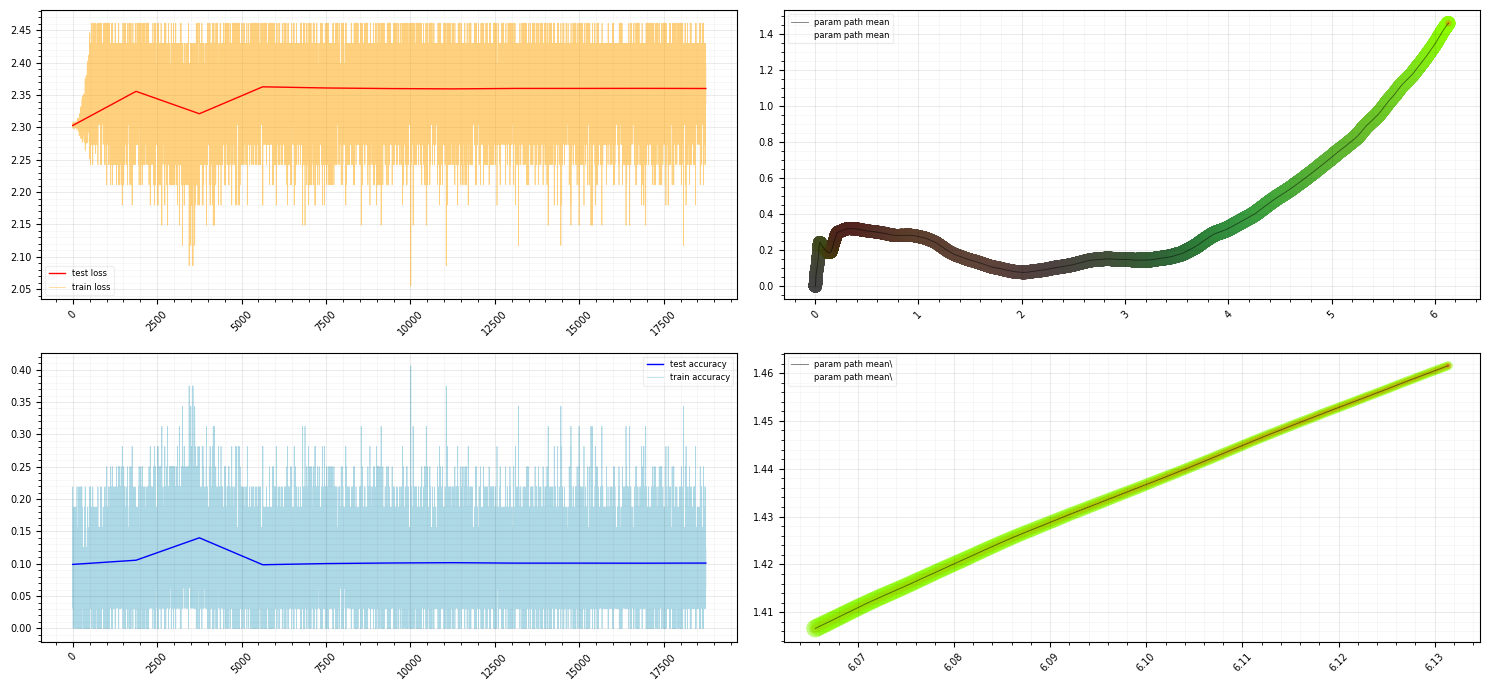

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 41.11s/ops, elapsed: 06m:09s, rem: 41.11s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 235.85ops/s, elapsed: 1.32s, rem: 4ms | 
train loss:                              last = 2.399, min = 2.055, max = 2.461
test loss:                               last = 2.360, min = 2.303, max = 2.363
train accuracy:                          last = 0.062, min = 0.000, max = 0.406
test accuracy:                           last = 0.101, min = 0.098, max = 0.140

test loss: min: 2.3029; max: 2.3627; last: 2.3601
test accuracy: min: 0.0984; max: 0.1401; last: 0.1010
param mean: min: -0.2700; max: 0.4912; last: 0.4912
param var: min: 0.0026; max: 21689.1172; last: 21689.1172
param min: min: -620.8499; max: -0.2424; last: -620.8499
param max: min: 0.2470; max: 535.9398; last: 535.9398
update var: min: 0.0000; max: 0.0001; last: 0.0001
update angle: min: 0.0000; max: 0.0182; last: 0.0000
time: min: 1.5649; max: 417.6464; last: 417.6464
train loss: min: 2.0549; max: 2.4612; last: 2.3987
train accuracy: min: 0.0000; max: 0.4062; last: 0.0625
last updates std: min: 0.0000; max: 0.0044; last: 0.0001


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-4
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=1)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof1"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# vanilla 2nd-order random walk 1e-6 bestof 3 - 41% test accuracy and a dip
So without `bestof = 3` it doesn't seem to work. With it - better but still bad. A variable order random walk is needed.

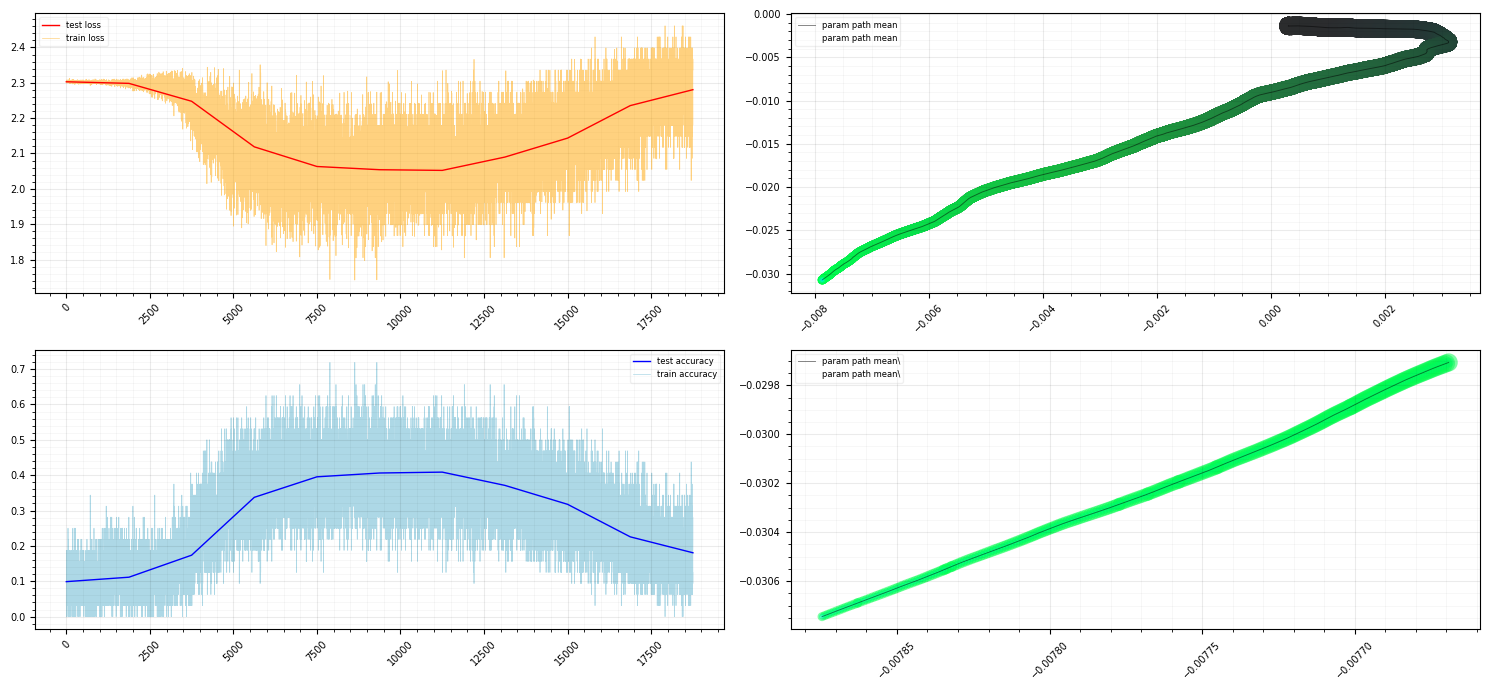

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 53.25s/ops, elapsed: 07m:59s, rem: 53.25s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 232.60ops/s, elapsed: 1.34s, rem: 4ms | 
train loss:                              last = 2.336, min = 1.742, max = 2.461
test loss:                               last = 2.235, min = 2.052, max = 2.303
train accuracy:                          last = 0.125, min = 0.000, max = 0.719
test accuracy:                           last = 0.226, min = 0.099, max = 0.409

test loss: min: 2.0522; max: 2.3029; last: 2.2805
test accuracy: min: 0.0989; max: 0.4086; last: 0.1806
param mean: min: 0.0001; max: 0.0039; last: 0.0039
param var: min: 0.0026; max: 1.0967; last: 1.0967
param min: min: -3.9249; max: -0.2488; last: -3.9249
param max: min: 0.2484; max: 4.2053; last: 4.2053
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0006; last: 0.0001
time: min: 1.5710; max: 548.1114; last: 548.1114
train loss: min: 1.7419; max: 2.4612; last: 2.3362
train accuracy: min: 0.0000; max: 0.7188; last: 0.1250
last updates std: min: 0.0000; max: 0.0001; last: 0.0000


In [5]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-6
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=3)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof3"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

# 2nd order random walk 1e-5 bestof3 with 1e-1 L1 regularization
Since weights clearly get too big, logical thing is to add regularization

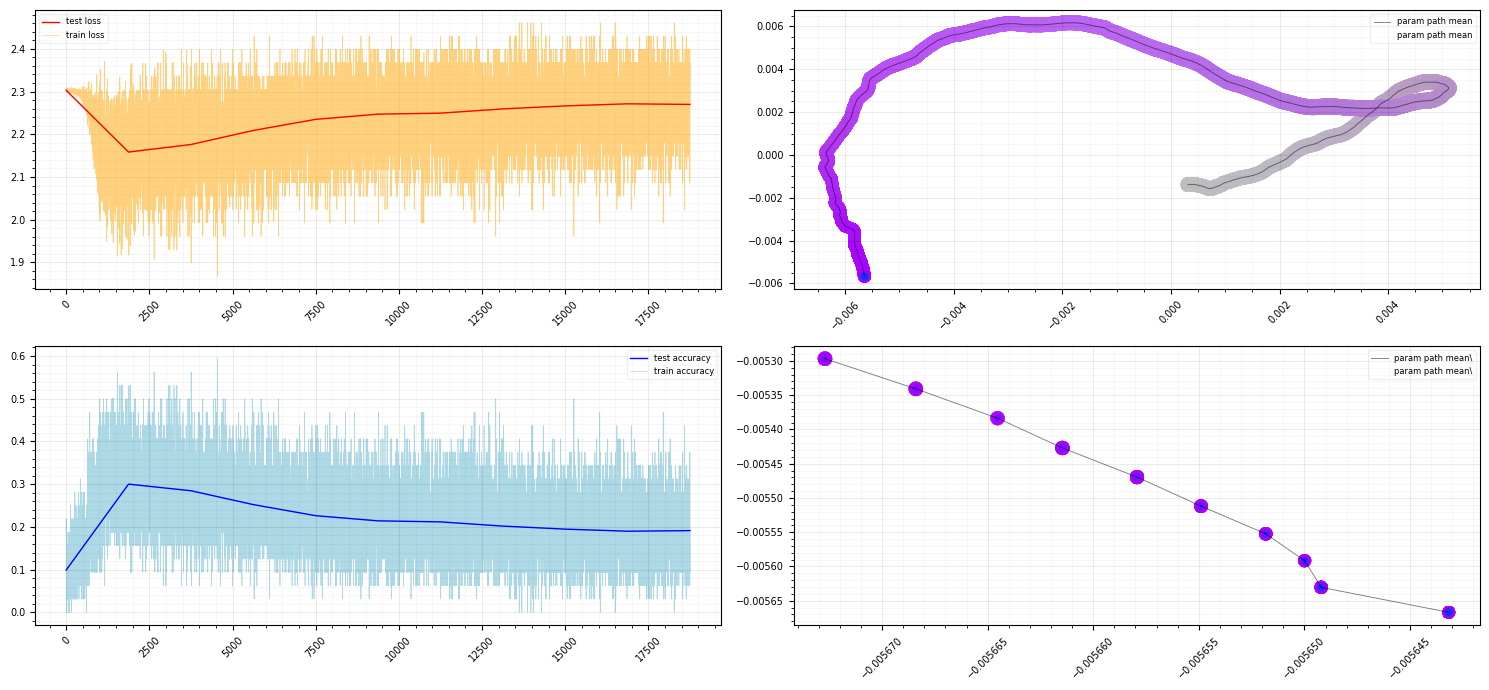

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:17s/ops, elapsed: 11m:35s, rem: 01m:17s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 160.03ops/s, elapsed: 1.95s, rem: 6ms | 
train loss:                              last = 2.274, min = 1.867, max = 2.461
test loss:                               last = 2.271, min = 2.158, max = 2.303
train accuracy:                          last = 0.188, min = 0.000, max = 0.594
test accuracy:                           last = 0.190, min = 0.099, max = 0.300

test loss: min: 2.1583; max: 2.3029; last: 2.2699
test accuracy: min: 0.0989; max: 0.3001; last: 0.1913
param mean: min: -0.0058; max: 0.0019; last: -0.0058
param var: min: 0.0026; max: 1.2905; last: 1.2905
param min: min: -4.2525; max: -0.2493; last: -4.2525
param max: min: 0.2485; max: 4.4072; last: 4.4072
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0028; last: 0.0000
time: min: 2.0127; max: 774.9918; last: 774.9918
train loss: min: 1.8674; max: 2.4612; last: 2.2737
train accuracy: min: 0.0000; max: 0.5938; last: 0.1875
last updates std: min: 0.0000; max: 0.0008; last: 0.0000


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [2]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-5
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=3, L1 = 0.1)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof3"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

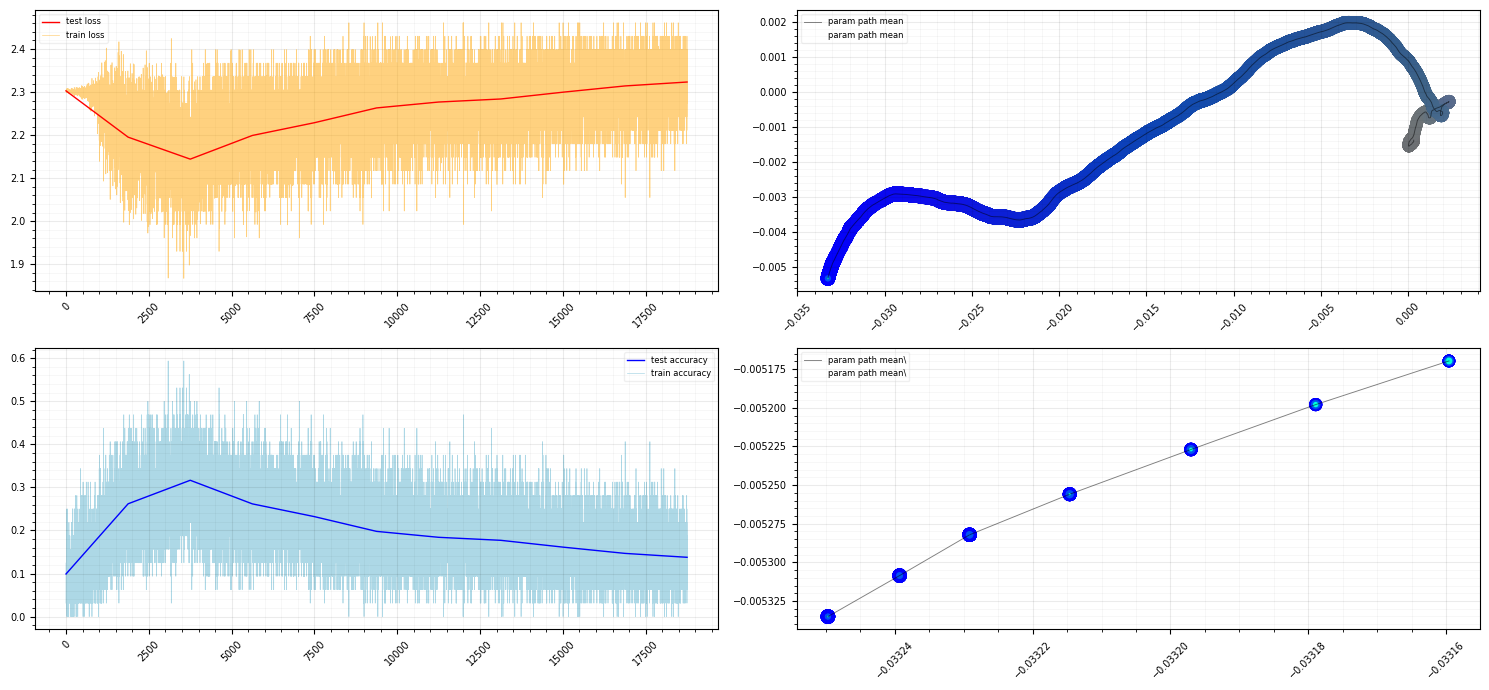

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:25s/ops, elapsed: 12m:47s, rem: 01m:25s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 262.62ops/s, elapsed: 1.19s, rem: 4ms | 
train loss:                              last = 2.399, min = 1.867, max = 2.461
test loss:                               last = 2.314, min = 2.144, max = 2.314
train accuracy:                          last = 0.062, min = 0.000, max = 0.594
test accuracy:                           last = 0.147, min = 0.099, max = 0.317

test loss: min: 2.1442; max: 2.3235; last: 2.3235
test accuracy: min: 0.0989; max: 0.3166; last: 0.1377
param mean: min: -0.0001; max: 0.0015; last: -0.0001
param var: min: 0.0026; max: 1.3175; last: 1.3175
param min: min: -4.3179; max: -0.2492; last: -4.3179
param max: min: 0.2475; max: 5.0697; last: 5.0697
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0029; last: 0.0000
time: min: 1.9261; max: 839.7341; last: 839.7341
train loss: min: 1.8670; max: 2.4612; last: 2.3987
train accuracy: min: 0.0000; max: 0.5938; last: 0.0625
last updates std: min: 0.0000; max: 0.0008; last: 0.0000


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


In [3]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-5
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=3, L1 = 0.5)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof3 L1 0.5"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

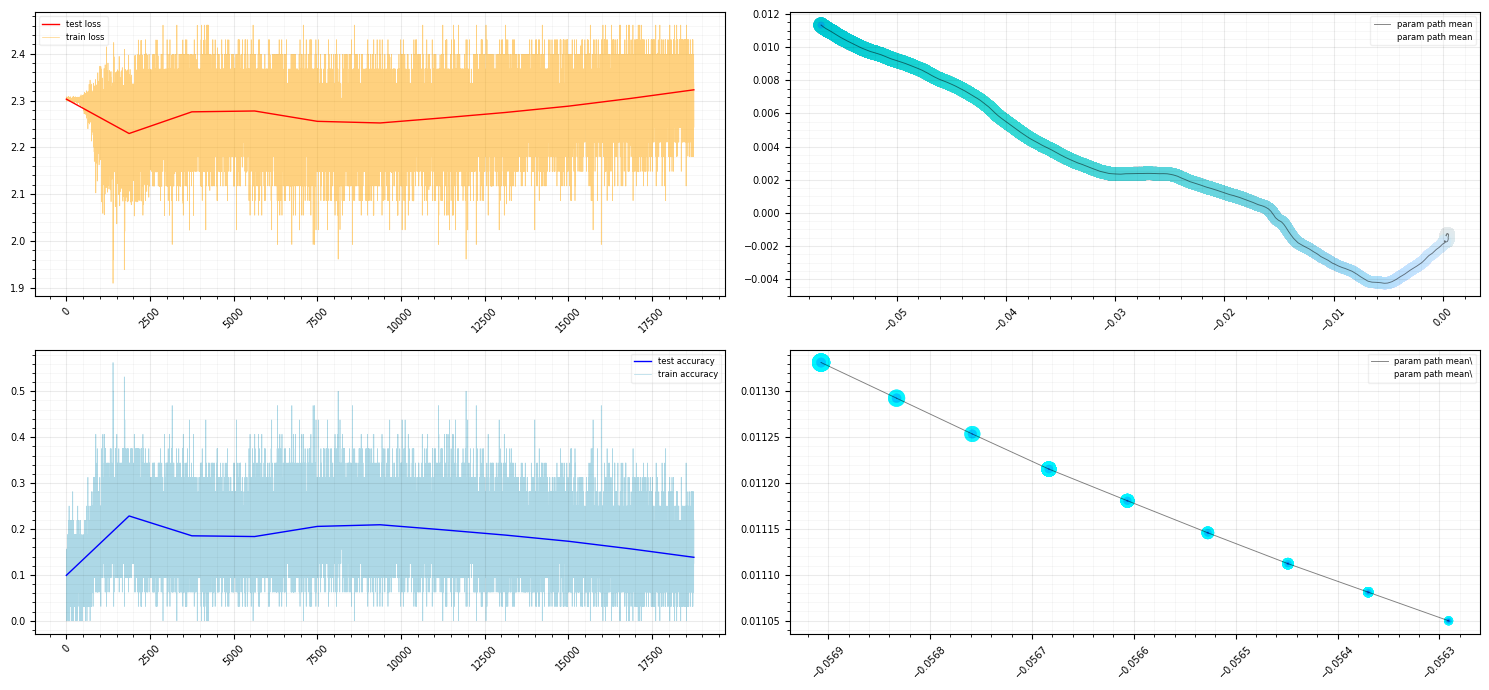

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:30s/ops, elapsed: 13m:38s, rem: 01m:30s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 139.22ops/s, elapsed: 2.24s, rem: 7ms | 
train loss:                              last = 2.336, min = 1.910, max = 2.461
test loss:                               last = 2.305, min = 2.230, max = 2.305
train accuracy:                          last = 0.125, min = 0.000, max = 0.562
test accuracy:                           last = 0.157, min = 0.099, max = 0.228

test loss: min: 2.2295; max: 2.3228; last: 2.3228
test accuracy: min: 0.0989; max: 0.2283; last: 0.1383
param mean: min: -0.0115; max: 0.0001; last: -0.0115
param var: min: 0.0026; max: 1.1983; last: 1.1983
param min: min: -4.4923; max: -0.2486; last: -4.4923
param max: min: 0.2435; max: 4.1935; last: 4.1935
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0028; last: 0.0000
time: min: 1.5997; max: 901.5467; last: 901.5467
train loss: min: 1.9095; max: 2.4612; last: 2.3362
train accuracy: min: 0.0000; max: 0.5625; last: 0.1250
last updates std: min: 0.0000; max: 0.0008; last: 0.0000


In [4]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-5
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=3, L2 = 0.1)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof3 L2 0.1"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

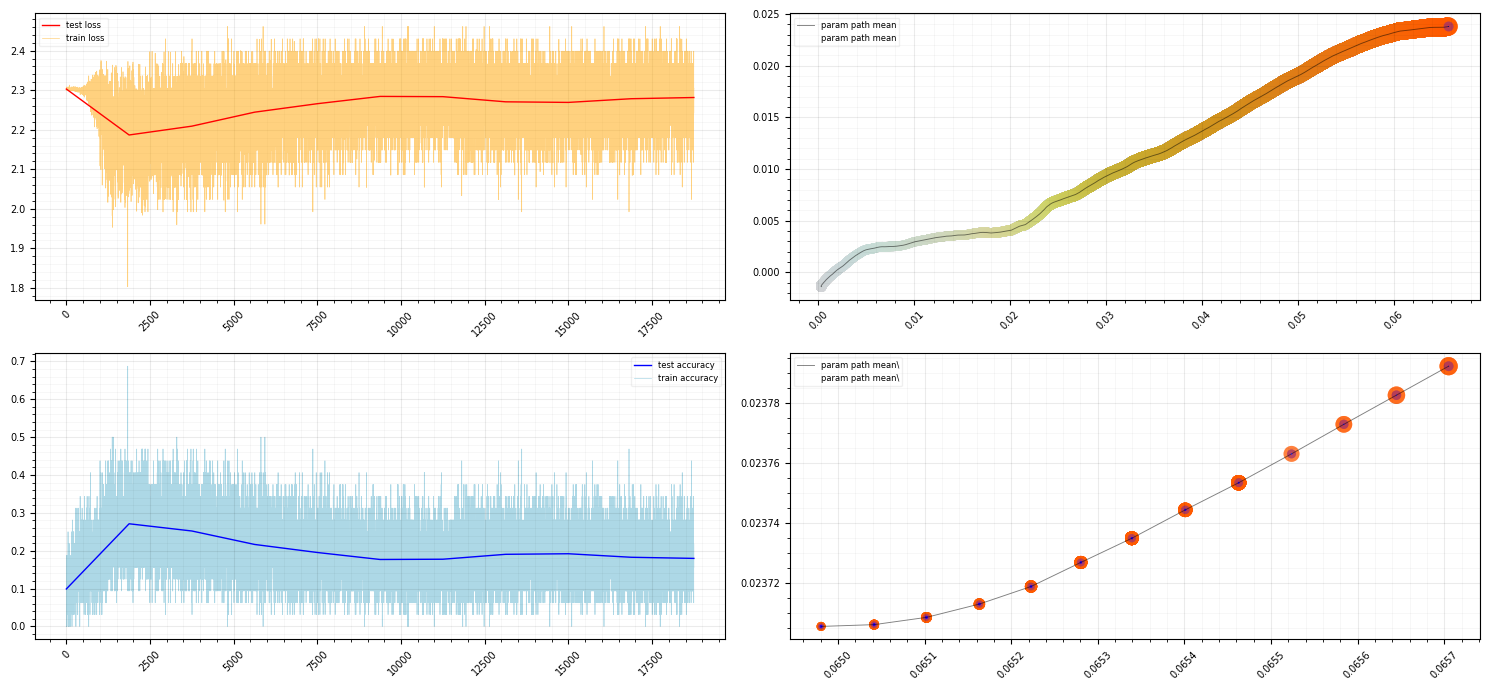

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:14s/ops, elapsed: 11m:08s, rem: 01m:14s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 230.27ops/s, elapsed: 1.35s, rem: 4ms | 
train loss:                              last = 2.305, min = 1.803, max = 2.461
test loss:                               last = 2.278, min = 2.187, max = 2.303
train accuracy:                          last = 0.156, min = 0.000, max = 0.688
test accuracy:                           last = 0.183, min = 0.099, max = 0.271

test loss: min: 2.1867; max: 2.3029; last: 2.2815
test accuracy: min: 0.0989; max: 0.2712; last: 0.1797
param mean: min: -0.0003; max: 0.0051; last: 0.0051
param var: min: 0.0026; max: 1.1272; last: 1.1272
param min: min: -4.2357; max: -0.2489; last: -4.2357
param max: min: 0.2485; max: 4.2297; last: 4.2297
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0030; last: 0.0000
time: min: 1.6853; max: 747.5669; last: 747.5669
train loss: min: 1.8029; max: 2.4612; last: 2.3049
train accuracy: min: 0.0000; max: 0.6875; last: 0.1562
last updates std: min: 0.0000; max: 0.0008; last: 0.0000


In [5]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-5
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=3, L2 = 0.5)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof3 L2 0.5"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

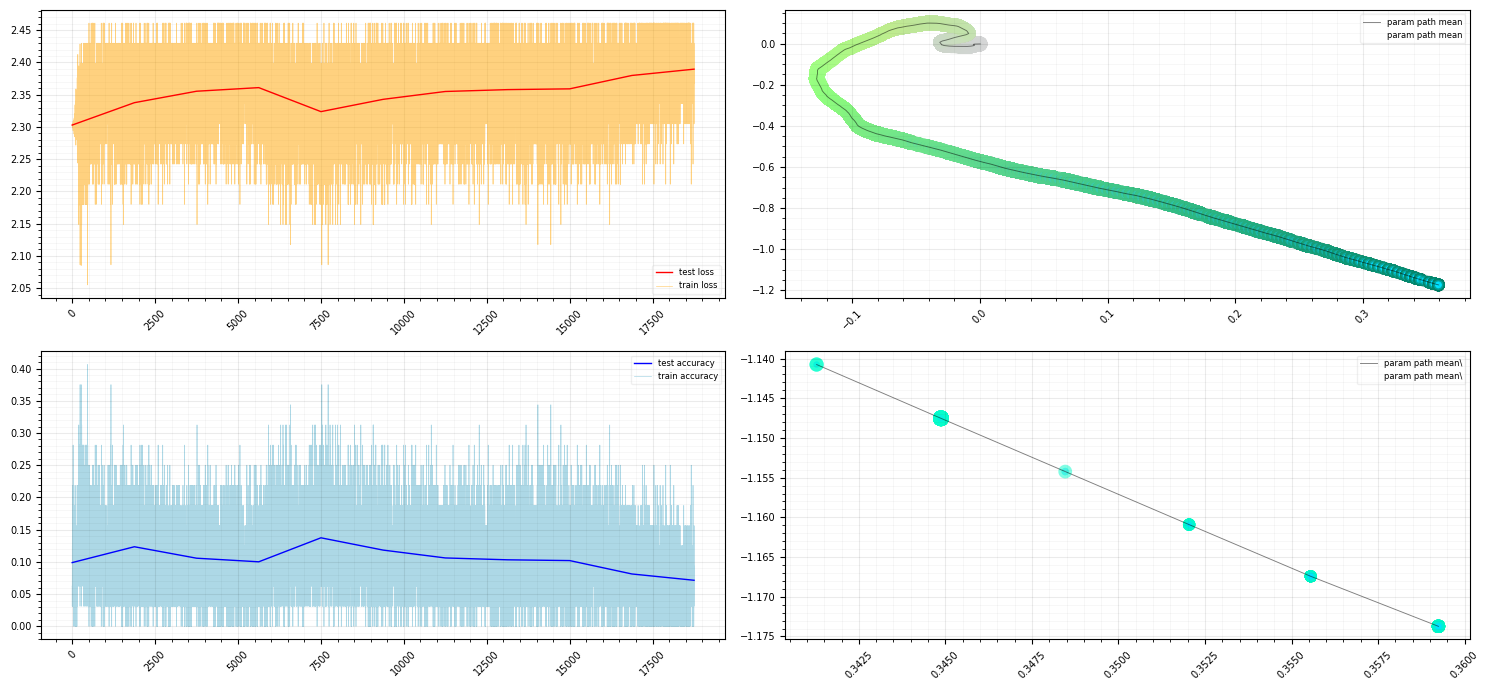

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:31s/ops, elapsed: 13m:46s, rem: 01m:31s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 254.56ops/s, elapsed: 1.23s, rem: 4ms | 
train loss:                              last = 2.367, min = 2.055, max = 2.461
test loss:                               last = 2.380, min = 2.303, max = 2.380
train accuracy:                          last = 0.094, min = 0.000, max = 0.406
test accuracy:                           last = 0.081, min = 0.081, max = 0.137

test loss: min: 2.3029; max: 2.3897; last: 2.3897
test accuracy: min: 0.0715; max: 0.1374; last: 0.0715
param mean: min: -0.2330; max: 0.0001; last: -0.2330
param var: min: 0.0026; max: 836.3601; last: 836.3601
param min: min: -116.0663; max: -0.2481; last: -116.0663
param max: min: 0.2488; max: 104.1539; last: 104.1539
update var: min: 0.0000; max: 0.0066; last: 0.0000
update angle: min: 0.0000; max: 0.0934; last: 0.0000
time: min: 2.5671; max: 936.0414; last: 936.0414
train loss: min: 2.0549; max: 2.4612; last: 2.3674
train accuracy: min: 0.0000; max: 0.4062; last: 0.0938
last updates std: min: 0.0000; max: 0.0810; last: 0.0000


In [6]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=3, L1 = 0.5)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof3 L1 0.5"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)

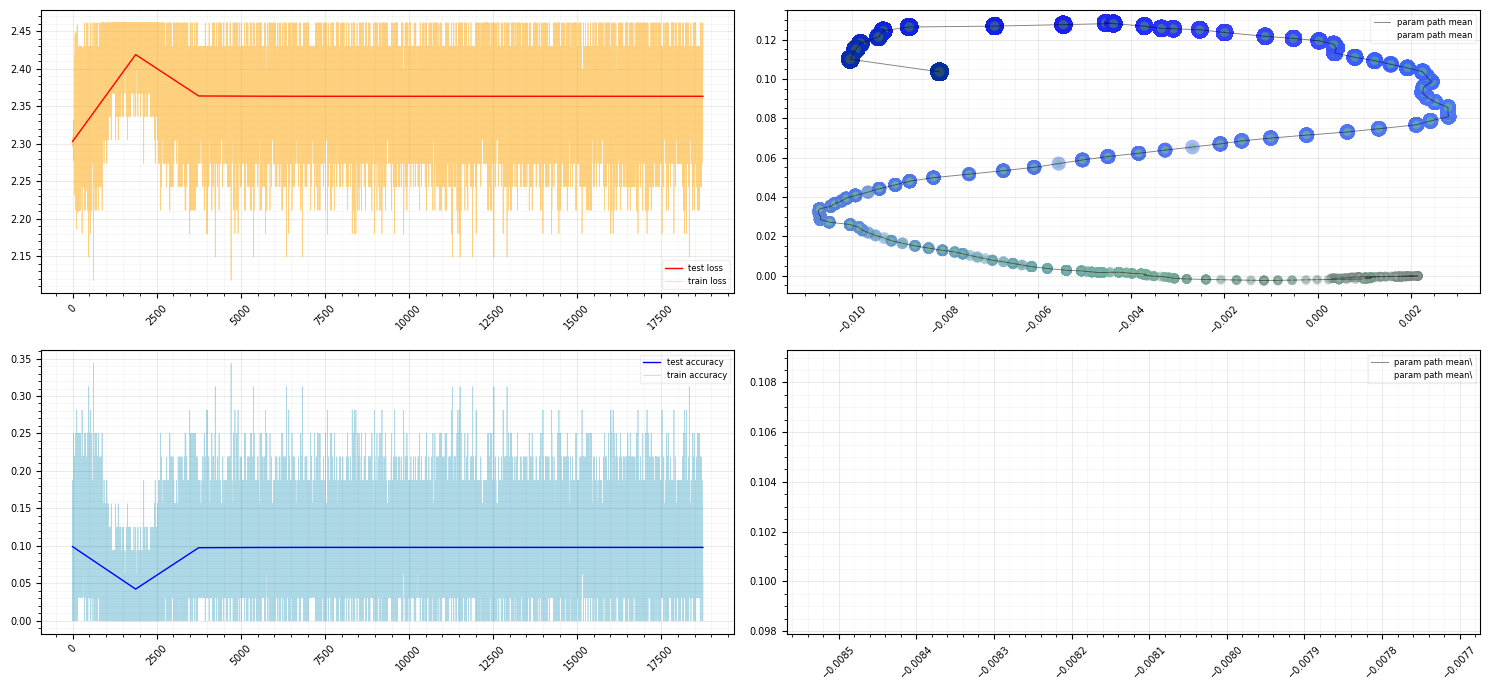

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 01m:22s/ops, elapsed: 12m:22s, rem: 01m:22s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 265.52ops/s, elapsed: 1.18s, rem: 4ms | 
train loss:                              last = 2.399, min = 2.117, max = 2.461
test loss:                               last = 2.363, min = 2.303, max = 2.419
train accuracy:                          last = 0.062, min = 0.000, max = 0.344
test accuracy:                           last = 0.098, min = 0.042, max = 0.099

test loss: min: 2.3029; max: 2.4188; last: 2.3632
test accuracy: min: 0.0423; max: 0.0989; last: 0.0979
param mean: min: 0.0000; max: 0.0198; last: 0.0042
param var: min: 0.0026; max: 10.8291; last: 10.8291
param min: min: -14.1213; max: -0.2484; last: -14.1213
param max: min: 0.2485; max: 14.9932; last: 14.9032
update var: min: 0.0000; max: 0.0060; last: 0.0000
update angle: min: 0.0000; max: 0.0615; last: 0.0000
time: min: 2.7032; max: 821.2120; last: 821.2120
train loss: min: 2.1174; max: 2.4612; last: 2.3987
train accuracy: min: 0.0000; max: 0.3438; last: 0.0625
last updates std: min: 0.0000; max: 0.0772; last: 0.0000


In [7]:
from torchzero.optim import RandomWalk
with seeded_rng(): MODEL = CNN()
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

OPT = RandomWalk(MODEL.parameters(), lr=LR, order=2, best_of=3, L2 = 0.5)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"2nd-order random walk {LR:.0e} bestof3 L2 0.5"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)